In [1]:
# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys

# tvm, relay
import tvm
from tvm import te
from tvm import relay
from ctypes import *
from tvm.contrib.download import download_testdata
from tvm.relay.testing.darknet import __darknetffi__
import tvm.relay.testing.yolo_detection
import tvm.relay.testing.darknet

from tvm.contrib import relay_viz

In [2]:
# Model name
MODEL_NAME = "yolov3"

In [3]:
CFG_NAME = MODEL_NAME + ".cfg"
WEIGHTS_NAME = MODEL_NAME + ".weights"
REPO_URL = "https://github.com/dmlc/web-data/blob/main/darknet/"
CFG_URL = REPO_URL + "cfg/" + CFG_NAME + "?raw=true"
WEIGHTS_URL = "https://pjreddie.com/media/files/" + WEIGHTS_NAME

cfg_path = download_testdata(CFG_URL, CFG_NAME, module="darknet")
weights_path = download_testdata(WEIGHTS_URL, WEIGHTS_NAME, module="darknet")

# Download and Load darknet library
if sys.platform in ["linux", "linux2"]:
    DARKNET_LIB = "libdarknet2.0.so"
    DARKNET_URL = REPO_URL + "lib/" + DARKNET_LIB + "?raw=true"
elif sys.platform == "darwin":
    DARKNET_LIB = "libdarknet_mac2.0.so"
    DARKNET_URL = REPO_URL + "lib_osx/" + DARKNET_LIB + "?raw=true"
else:
    err = "Darknet lib is not supported on {} platform".format(sys.platform)
    raise NotImplementedError(err)

lib_path = download_testdata(DARKNET_URL, DARKNET_LIB, module="darknet")

DARKNET_LIB = __darknetffi__.dlopen(lib_path)
net = DARKNET_LIB.load_network(cfg_path.encode("utf-8"), weights_path.encode("utf-8"), 0)
dtype = "float32"
batch_size = 1

data = np.empty([batch_size, net.c, net.h, net.w], dtype)
shape_dict = {"data": data.shape}
print("Converting darknet to relay functions...")
mod, params = relay.frontend.from_darknet(net, dtype=dtype, shape=data.shape)

Converting darknet to relay functions...


In [6]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
data = np.empty([batch_size, net.c, net.h, net.w], dtype)
shape = {"data": data.shape}
print("Compiling the model...")
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

[neth, netw] = shape["data"][2:]  # Current image shape is 608x608

Compiling the model...


[14:05:18] /home/wendell/Desktop/tvm/src/runtime/threading_backend.cc:320: Warning: more than two frequencies detected!
One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [21]:
# test_image = "dog.jpg"
# print("Loading the test image...")
# img_url = REPO_URL + "data/" + test_image + "?raw=true"
# img_path = download_testdata(img_url, test_image, "data")

img_path = '/home/wendell/.tvm_test_data/data/imagenet_cat.png'
data = tvm.relay.testing.darknet.load_image(img_path, netw, neth)

Running the test image...
class:['cat 0.9972'] left:226 top:67 right:588 bottom:641


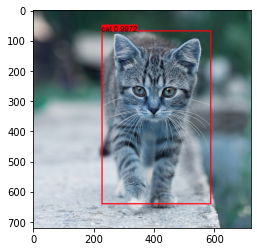

In [22]:
from tvm.contrib import graph_executor

m = graph_executor.GraphModule(lib["default"](dev))

# set inputs
m.set_input("data", tvm.nd.array(data.astype(dtype)))
# execute
print("Running the test image...")

# detection
# thresholds
thresh = 0.5
nms_thresh = 0.45

m.run()
# get outputs
tvm_out = []
if MODEL_NAME == "yolov2":
    layer_out = {}
    layer_out["type"] = "Region"
    # Get the region layer attributes (n, out_c, out_h, out_w, classes, coords, background)
    layer_attr = m.get_output(2).numpy()
    layer_out["biases"] = m.get_output(1).numpy()
    out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
    layer_out["output"] = m.get_output(0).numpy().reshape(out_shape)
    layer_out["classes"] = layer_attr[4]
    layer_out["coords"] = layer_attr[5]
    layer_out["background"] = layer_attr[6]
    tvm_out.append(layer_out)

elif MODEL_NAME == "yolov3":
    for i in range(3):
        layer_out = {}
        layer_out["type"] = "Yolo"
        # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
        layer_attr = m.get_output(i * 4 + 3).numpy()
        layer_out["biases"] = m.get_output(i * 4 + 2).numpy()
        layer_out["mask"] = m.get_output(i * 4 + 1).numpy()
        out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
        layer_out["output"] = m.get_output(i * 4).numpy().reshape(out_shape)
        layer_out["classes"] = layer_attr[4]
        tvm_out.append(layer_out)

elif MODEL_NAME == "yolov3-tiny":
    for i in range(2):
        layer_out = {}
        layer_out["type"] = "Yolo"
        # Get the yolo layer attributes (n, out_c, out_h, out_w, classes, total)
        layer_attr = m.get_output(i * 4 + 3).numpy()
        layer_out["biases"] = m.get_output(i * 4 + 2).numpy()
        layer_out["mask"] = m.get_output(i * 4 + 1).numpy()
        out_shape = (layer_attr[0], layer_attr[1] // layer_attr[0], layer_attr[2], layer_attr[3])
        layer_out["output"] = m.get_output(i * 4).numpy().reshape(out_shape)
        layer_out["classes"] = layer_attr[4]
        tvm_out.append(layer_out)
        thresh = 0.560

# do the detection and bring up the bounding boxes
img = tvm.relay.testing.darknet.load_image_color(img_path)
_, im_h, im_w = img.shape
dets = tvm.relay.testing.yolo_detection.fill_network_boxes(
    (netw, neth), (im_w, im_h), thresh, 1, tvm_out
)
last_layer = net.layers[net.n - 1]
tvm.relay.testing.yolo_detection.do_nms_sort(dets, last_layer.classes, nms_thresh)

coco_name = "coco.names"
coco_url = REPO_URL + "data/" + coco_name + "?raw=true"
font_name = "arial.ttf"
font_url = REPO_URL + "data/" + font_name + "?raw=true"
coco_path = download_testdata(coco_url, coco_name, module="data")
font_path = download_testdata(font_url, font_name, module="data")

with open(coco_path) as f:
    content = f.readlines()

names = [x.strip() for x in content]

tvm.relay.testing.yolo_detection.show_detections(img, dets, thresh, names, last_layer.classes)
tvm.relay.testing.yolo_detection.draw_detections(
    font_path, img, dets, thresh, names, last_layer.classes
)
plt.imshow(img.transpose(1, 2, 0))
plt.show()

In [24]:
from tvm import rpc
host = "0.0.0.0"
port = 9090 # port above
remote = rpc.connect(host, port)